In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
device_name = tf.test.gpu_device_name() #GPU Run Check
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/splitlabel/'
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/467case_cut/'
os.listdir(DATA_PATH)

['뿌리-부재2.xlsx',
 '크기-나무-크다.xlsx',
 'test_가지-부재.xlsx',
 '위치-나무-정중앙.xlsx',
 'train_위치-나무-정중앙.xlsx',
 '수관-공 모양.xlsx',
 'sub_가지-부재.xlsx',
 '크기-사람-작다.xlsx',
 '위치-사람-정중앙.xlsx',
 'train_위치-나무-아래.xlsx',
 'sub_기둥-상처, 옹이구멍.xlsx',
 'train_뿌리-부재2.xlsx',
 '기둥-옹이구멍 안 동물.xlsx',
 'test_뿌리-부재1.xlsx',
 'train_수관-공 모양.xlsx',
 'sub_위치-나무-위.xlsx',
 '손-정교함(손톱, 주름).xlsx',
 '위치-나무-위.xlsx',
 'train_가지-부재.xlsx',
 '머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 '가지-부재.xlsx',
 '문-격자무늬 창.xlsx',
 '절단-나무-위.xlsx',
 'sub_위치-나무-아래.xlsx',
 'test_절단-나무-오른쪽.xlsx',
 'sub_뿌리-부재1.xlsx',
 'test_위치-나무-아래.xlsx',
 '손-부재.xlsx',
 '창문-많다.xlsx',
 'train_가지-옆으로 벌어짐.xlsx',
 '위치-사람-오른쪽.xlsx',
 'train_기둥-상처, 옹이구멍.xlsx',
 'test_기둥-상처, 옹이구멍.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 'train_크기-나무-크다.xlsx',
 'sub_절단-나무-위.xlsx',
 'sub_가지-아래로 늘어진 가지.xlsx',
 'train_위치-나무-위.xlsx',
 '창문-격자무늬.xlsx',
 'test_절단-나무-위.xlsx',
 '다리-넓게 벌림.xlsx',
 'test_수관-공 모양.xlsx',
 '위치-나무-아래.xlsx',
 '다리-앉아있음.xlsx',
 '위치-집-아래.xlsx',
 'sub_절단-나무-오른쪽.xlsx',
 'sub_기둥-옹이구멍 안 동물.xlsx',
 '가지-아

In [0]:
tree = ['크기-나무-크다',
           '위치-나무-정중앙',
            '위치-나무-아래',
            '위치-나무-위',
            '절단-나무-위',
            '절단-나무-오른쪽',
            '가지-아래로 늘어진 가지',
            # '뿌리-부재1',
            '수관-공 모양',
            '기둥-옹이구멍 안 동물',
            '가지-부재',
            '뿌리-부재2',
            '가지-옆으로 벌어짐',
            '기둥-상처, 옹이구멍'
            ]

In [0]:
# TRAIN_CROP_PATH = '/Users/Il-hyeon/Documents/Data/train_crop'
TRAIN_IMG_PATH = os.path.join(IMG_PATH, 'tree')

df_train = []
df_test = []
for excel_name in tree:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH, 'train_' + excel_name + '.xlsx')))
    df_train[tree.index(excel_name)]['data'] = df_train[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH, 'test_' + excel_name + '.xlsx')))
    df_test[tree.index(excel_name)]['data'] = df_test[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [7]:
for i in range(len(tree)):
    print(df_train[i].head())
    print(df_test[i].head())

   Unnamed: 0        data  크기-나무-크다
0         174  0200_T.jpg         1
1         272  0317_T.jpg         1
2         170  0196_T.jpg         1
3           8  0009_T.jpg         1
4         214  0245_T.jpg         1
   Unnamed: 0        data  크기-나무-크다
0         433  0502_T.jpg         1
1          71  0072_T.jpg         0
2           7  0008_T.jpg         1
3         352  0421_T.jpg         1
4         444  0513_T.jpg         1
   Unnamed: 0        data  위치-나무-정중앙
0         220  0252_T.jpg          0
1         363  0432_T.jpg          0
2         394  0463_T.jpg          0
3         142  0159_T.jpg          0
4          41  0042_T.jpg          0
   Unnamed: 0        data  위치-나무-정중앙
0         442  0511_T.jpg          0
1         324  0393_T.jpg          0
2         159  0182_T.jpg          0
3         269  0312_T.jpg          0
4         101  0102_T.jpg          0
   Unnamed: 0        data  위치-나무-아래
0         253  0292_T.jpg         0
1         375  0444_T.jpg         1
2          69  0

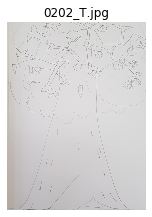

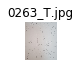

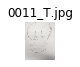

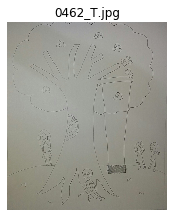

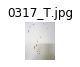

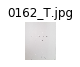

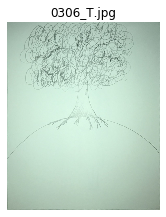

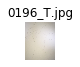

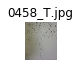

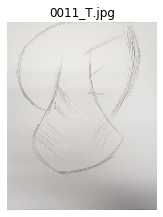

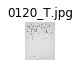

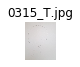

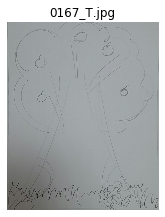

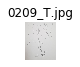

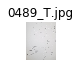

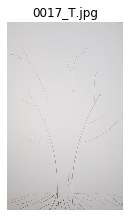

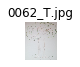

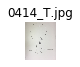

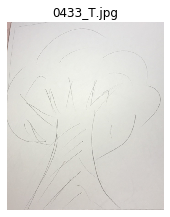

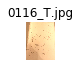

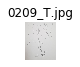

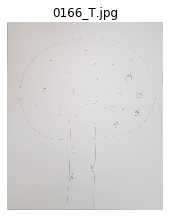

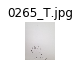

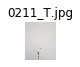

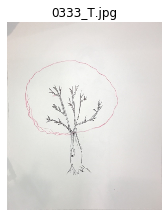

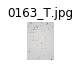

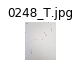

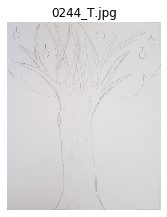

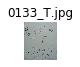

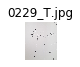

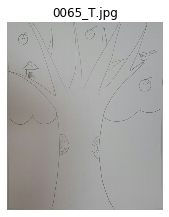

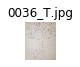

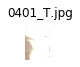

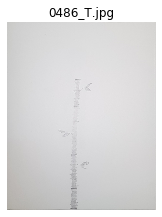

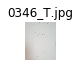

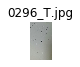

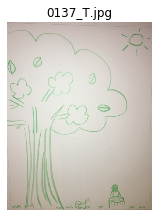

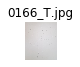

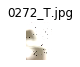

In [8]:
for i in range(len(df_train)):
    tmp_img = df_train[i]['data'][100:103]
    plt.figure(figsize=(12, 20))
    
    for num, f_name in enumerate(tmp_img):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X_train = []
X_val = []

for i, data in enumerate(tree):
    df_train[i][data] = df_train[i][data].astype('str')
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]
    
    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, test_size = 0.2, random_state = 42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])
    
    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print(df_test[i].shape)
    print('='*20)

크기-나무-크다
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-정중앙
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-아래
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-오른쪽
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-아래로 늘어진 가지
(298, 2)
(75, 2)
(373, 2)
(94, 1)
수관-공 모양
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-옹이구멍 안 동물
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-부재
(298, 2)
(75, 2)
(373, 2)
(94, 1)
뿌리-부재2
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-옆으로 벌어짐
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-상처, 옹이구멍
(298, 2)
(75, 2)
(373, 2)
(94, 1)


In [0]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [11]:
epochs = 20
batch_size = 32
img_size = (224, 224)
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False, 
    rotation_range = 3,   # image random roation
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(tree):
        nb_train_samples.append(len(X_train[i]))
        nb_validation_samples.append(len(X_val[i]))
        nb_test_samples.append(len(df_test[i]))
        
        train_generator.append(train_datagen.flow_from_dataframe(
            dataframe=X_train[i],
            directory=TRAIN_IMG_PATH,
            x_col = 'data',
            y_col = tree[i],
            target_size = img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            seed=42
        ))
        
        validation_generator.append(val_datagen.flow_from_dataframe(
            dataframe=X_val[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=tree[i],
            target_size=img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=False
        ))
        
        test_generator.append(test_datagen.flow_from_dataframe(
            dataframe=df_test[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=None,
            target_size = img_size,
            color_mode='rgb',
            class_mode=None,
            batch_size=batch_size,
            shuffle=False
        ))

Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 v

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [13]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax', kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
    
model = MakeMobileModel()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = []

for i in range(len(tree)):
    model = MakeMobileModel()
    filepath = tree[i] + '_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5'
  
    # ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
    ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    
    callbackList = [ckpt]
    
    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = 10,
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 1:36 - loss: 0.9670 - acc: 0.6400
Epoch 00001: val_loss improved from inf to 0.96703, saving model to 크기-나무-크다_mobile_model_0.64_0.9670.h5
10/10 [==============================] - 219s 22s/step - loss: 1.0624 - acc: 0.6745 - val_loss: 0.9670 - val_acc: 0.6400
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.9747 - acc: 0.6800
Epoch 00002: val_loss did not improve from 0.96703
10/10 [==============================] - 6s 563ms/step - loss: 0.4036 - acc: 0.8557 - val_loss: 0.9747 - val_acc: 0.6800
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 8.0846 - acc: 0.3067
Epoch 00003: val_loss did not improve from 0.96703
10/10 [==============================] - 10s 1s/step - loss: 0.2792 - acc: 0.9094 - val_loss: 8.0846 - val_acc: 0.3067
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 11.4533 - acc: 0.3067
Epoch 00004: val_loss did not improve from 0.96703
10/10 [===============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 23s - loss: 0.5991 - acc: 0.9733
Epoch 00001: val_loss improved from inf to 0.59908, saving model to 위치-나무-정중앙_mobile_model_0.97_0.5991.h5
10/10 [==============================] - 56s 6s/step - loss: 0.1957 - acc: 0.9564 - val_loss: 0.5991 - val_acc: 0.9733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.1622 - acc: 0.9600
Epoch 00002: val_loss improved from 0.59908 to 0.16220, saving model to 위치-나무-정중앙_mobile_model_0.96_0.1622.h5
10/10 [==============================] - 6s 576ms/step - loss: 0.1211 - acc: 0.9597 - val_loss: 0.1622 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5843 - acc: 0.8133
Epoch 00003: val_loss did not improve from 0.16220
10/10 [==============================] - 10s 1s/step - loss: 0.0415 - acc: 0.9832 - val_loss: 0.5843 - val_acc: 0.8133
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2760 - acc: 0.9333
Epoch 00004: val_

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 11s - loss: 7.2442 - acc: 0.1200
Epoch 00001: val_loss improved from inf to 7.24419, saving model to 위치-나무-아래_mobile_model_0.12_7.2442.h5
10/10 [==============================] - 26s 3s/step - loss: 0.6067 - acc: 0.8221 - val_loss: 7.2442 - val_acc: 0.1200
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3739 - acc: 0.8667
Epoch 00002: val_loss improved from 7.24419 to 0.37392, saving model to 위치-나무-아래_mobile_model_0.87_0.3739.h5
10/10 [==============================] - 6s 607ms/step - loss: 0.2666 - acc: 0.9228 - val_loss: 0.3739 - val_acc: 0.8667
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.6433 - acc: 0.8800
Epoch 00003: val_loss did not improve from 0.37392
10/10 [==============================] - 10s 1s/step - loss: 0.1314 - acc: 0.9564 - val_loss: 0.6433 - val_acc: 0.8800
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.8303 - acc: 0.6000
Epoch 00004: val_lo

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 21s - loss: 3.0071 - acc: 0.2969
Epoch 00001: val_loss improved from inf to 3.19811, saving model to 위치-나무-위_mobile_model_0.28_3.1981.h5
10/10 [==============================] - 27s 3s/step - loss: 1.0830 - acc: 0.6980 - val_loss: 3.1981 - val_acc: 0.2800
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.1351 - acc: 0.7333
Epoch 00002: val_loss improved from 3.19811 to 2.13508, saving model to 위치-나무-위_mobile_model_0.73_2.1351.h5
10/10 [==============================] - 6s 582ms/step - loss: 0.5050 - acc: 0.8322 - val_loss: 2.1351 - val_acc: 0.7333
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.2718 - acc: 0.7333
Epoch 00003: val_loss did not improve from 2.13508
10/10 [==============================] - 10s 1s/step - loss: 0.2197 - acc: 0.8993 - val_loss: 2.2718 - val_acc: 0.7333
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.6392 - acc: 0.7333
Epoch 00004: val_loss

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 24s - loss: 2.7870 - acc: 0.5312
Epoch 00001: val_loss improved from inf to 2.53796, saving model to 절단-나무-위_mobile_model_0.55_2.5380.h5
10/10 [==============================] - 29s 3s/step - loss: 1.1198 - acc: 0.6074 - val_loss: 2.5380 - val_acc: 0.5467
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.3786 - acc: 0.6933
Epoch 00002: val_loss improved from 2.53796 to 1.37859, saving model to 절단-나무-위_mobile_model_0.69_1.3786.h5
10/10 [==============================] - 6s 583ms/step - loss: 0.3448 - acc: 0.8758 - val_loss: 1.3786 - val_acc: 0.6933
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.8795 - acc: 0.6133
Epoch 00003: val_loss did not improve from 1.37859
10/10 [==============================] - 10s 1s/step - loss: 0.2604 - acc: 0.9228 - val_loss: 1.8795 - val_acc: 0.6133
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.3436 - acc: 0.7067
Epoch 00004: val_loss

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 25s - loss: 8.8298 - acc: 0.7188 
Epoch 00001: val_loss improved from inf to 10.81360, saving model to 절단-나무-오른쪽_mobile_model_0.69_10.8136.h5
10/10 [==============================] - 32s 3s/step - loss: 0.8530 - acc: 0.6946 - val_loss: 10.8136 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 4.3516 - acc: 0.4533
Epoch 00002: val_loss improved from 10.81360 to 4.35159, saving model to 절단-나무-오른쪽_mobile_model_0.45_4.3516.h5
10/10 [==============================] - 6s 605ms/step - loss: 0.4721 - acc: 0.8624 - val_loss: 4.3516 - val_acc: 0.4533
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 5.1810 - acc: 0.4800
Epoch 00003: val_loss did not improve from 4.35159
10/10 [==============================] - 11s 1s/step - loss: 0.2633 - acc: 0.9161 - val_loss: 5.1810 - val_acc: 0.4800
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.7120 - acc: 0.5867
Epoch 00004:

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 29s - loss: 0.2802 - acc: 0.9844     
Epoch 00001: val_loss improved from inf to 0.18678, saving model to 가지-아래로 늘어진 가지_mobile_model_0.99_0.1868.h5
10/10 [==============================] - 35s 4s/step - loss: 0.1210 - acc: 0.9664 - val_loss: 0.1868 - val_acc: 0.9867
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2246 - acc: 0.9867
Epoch 00002: val_loss did not improve from 0.18678
10/10 [==============================] - 6s 596ms/step - loss: 0.0433 - acc: 0.9899 - val_loss: 0.2246 - val_acc: 0.9867
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2731 - acc: 0.9867
Epoch 00003: val_loss did not improve from 0.18678
10/10 [==============================] - 11s 1s/step - loss: 0.0167 - acc: 0.9966 - val_loss: 0.2731 - val_acc: 0.9867
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.2856 - acc: 0.9867
Epoch 00004: val_loss did not improve from 0.18678
10/10 [=========

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 31s - loss: 1.1963 - acc: 0.5469 
Epoch 00001: val_loss improved from inf to 1.02094, saving model to 수관-공 모양_mobile_model_0.57_1.0209.h5
10/10 [==============================] - 38s 4s/step - loss: 0.4536 - acc: 0.8658 - val_loss: 1.0209 - val_acc: 0.5733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.1121 - acc: 0.9600
Epoch 00002: val_loss did not improve from 1.02094
10/10 [==============================] - 6s 576ms/step - loss: 0.1630 - acc: 0.9530 - val_loss: 1.1121 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.0024 - acc: 0.9600
Epoch 00003: val_loss improved from 1.02094 to 1.00243, saving model to 수관-공 모양_mobile_model_0.96_1.0024.h5
10/10 [==============================] - 11s 1s/step - loss: 0.1946 - acc: 0.9597 - val_loss: 1.0024 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.3108 - acc: 0.9600
Epoch 00004: val_los

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 20s - loss: 0.1753 - acc: 0.9733
Epoch 00001: val_loss improved from inf to 0.17527, saving model to 기둥-옹이구멍 안 동물_mobile_model_0.97_0.1753.h5
10/10 [==============================] - 41s 4s/step - loss: 0.4311 - acc: 0.8322 - val_loss: 0.1753 - val_acc: 0.9733
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.7505 - acc: 0.9600
Epoch 00002: val_loss did not improve from 0.17527
10/10 [==============================] - 6s 586ms/step - loss: 0.0591 - acc: 0.9732 - val_loss: 0.7505 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.1760 - acc: 0.9600
Epoch 00003: val_loss did not improve from 0.17527
10/10 [==============================] - 11s 1s/step - loss: 0.0182 - acc: 0.9966 - val_loss: 1.1760 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.4626 - acc: 0.9600
Epoch 00004: val_loss did not improve from 0.17527
10/10 [===============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 37s - loss: 3.4885 - acc: 0.2188 
Epoch 00001: val_loss improved from inf to 3.46532, saving model to 가지-부재_mobile_model_0.20_3.4653.h5
10/10 [==============================] - 43s 4s/step - loss: 0.5995 - acc: 0.8658 - val_loss: 3.4653 - val_acc: 0.2000
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.5067 - acc: 0.7467
Epoch 00002: val_loss improved from 3.46532 to 0.50668, saving model to 가지-부재_mobile_model_0.75_0.5067.h5
10/10 [==============================] - 6s 616ms/step - loss: 0.0917 - acc: 0.9664 - val_loss: 0.5067 - val_acc: 0.7467
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 0.4659 - acc: 0.7867
Epoch 00003: val_loss improved from 0.50668 to 0.46590, saving model to 가지-부재_mobile_model_0.79_0.4659.h5
10/10 [==============================] - 11s 1s/step - loss: 0.1842 - acc: 0.9497 - val_loss: 0.4659 - val_acc: 0.7867
Epoch 4/20
 3/10 [========>.....................] - ETA: 5

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 40s - loss: 11.2618 - acc: 0.4688 
Epoch 00001: val_loss improved from inf to 12.22014, saving model to 뿌리-부재2_mobile_model_0.45_12.2201.h5
10/10 [==============================] - 47s 5s/step - loss: 1.0237 - acc: 0.6510 - val_loss: 12.2201 - val_acc: 0.4533
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 19.0817 - acc: 0.4533
Epoch 00002: val_loss did not improve from 12.22014
10/10 [==============================] - 6s 590ms/step - loss: 0.2524 - acc: 0.8926 - val_loss: 19.0817 - val_acc: 0.4533
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 7.9999 - acc: 0.5067
Epoch 00003: val_loss improved from 12.22014 to 7.99994, saving model to 뿌리-부재2_mobile_model_0.51_7.9999.h5
10/10 [==============================] - 11s 1s/step - loss: 0.1160 - acc: 0.9530 - val_loss: 7.9999 - val_acc: 0.5067
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 5.9993 - acc: 0.5733
Epoch 00004: v

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 23s - loss: 1.4704 - acc: 0.8400
Epoch 00001: val_loss improved from inf to 1.47042, saving model to 가지-옆으로 벌어짐_mobile_model_0.84_1.4704.h5
10/10 [==============================] - 48s 5s/step - loss: 0.7605 - acc: 0.7248 - val_loss: 1.4704 - val_acc: 0.8400
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 4.1949 - acc: 0.8400
Epoch 00002: val_loss did not improve from 1.47042
10/10 [==============================] - 6s 581ms/step - loss: 0.2721 - acc: 0.9161 - val_loss: 4.1949 - val_acc: 0.8400
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.4258 - acc: 0.8400
Epoch 00003: val_loss did not improve from 1.47042
10/10 [==============================] - 11s 1s/step - loss: 0.2064 - acc: 0.9497 - val_loss: 2.4258 - val_acc: 0.8400
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 1.5243 - acc: 0.5733
Epoch 00004: val_loss did not improve from 1.47042
10/10 [=================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 2/10 [=====>........................] - ETA: 43s - loss: 5.8444 - acc: 0.5312 
Epoch 00001: val_loss improved from inf to 6.15450, saving model to 기둥-상처, 옹이구멍_mobile_model_0.52_6.1545.h5
10/10 [==============================] - 50s 5s/step - loss: 1.0721 - acc: 0.6242 - val_loss: 6.1545 - val_acc: 0.5200
Epoch 2/20
 3/10 [========>.....................] - ETA: 5s - loss: 2.1904 - acc: 0.6533
Epoch 00002: val_loss improved from 6.15450 to 2.19038, saving model to 기둥-상처, 옹이구멍_mobile_model_0.65_2.1904.h5
10/10 [==============================] - 6s 617ms/step - loss: 0.5314 - acc: 0.8154 - val_loss: 2.1904 - val_acc: 0.6533
Epoch 3/20
 3/10 [========>.....................] - ETA: 5s - loss: 5.5825 - acc: 0.5600
Epoch 00003: val_loss did not improve from 2.19038
10/10 [==============================] - 11s 1s/step - loss: 0.1704 - acc: 0.9329 - val_loss: 5.5825 - val_acc: 0.5600
Epoch 4/20
 3/10 [========>.....................] - ETA: 5s - loss: 8.2319 - acc: 0.5600
Epoch 00004:

크기-나무-크다


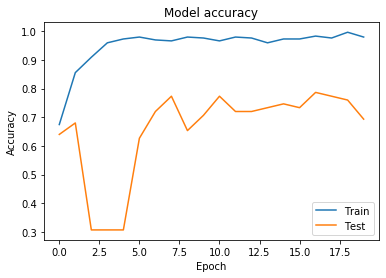

위치-나무-정중앙


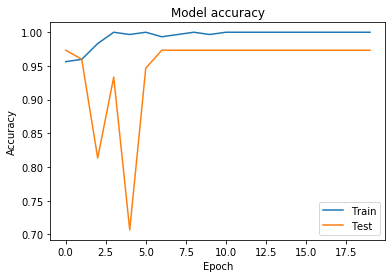

위치-나무-아래


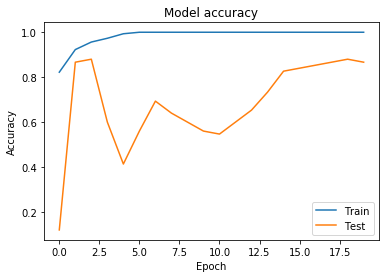

위치-나무-위


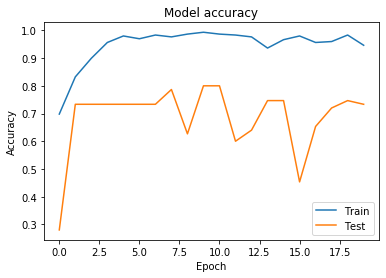

절단-나무-위


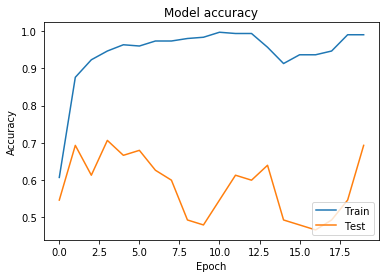

절단-나무-오른쪽


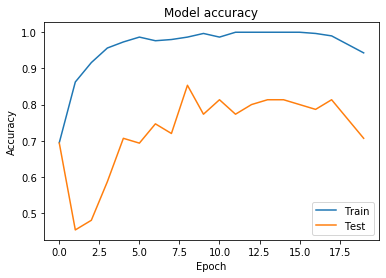

가지-아래로 늘어진 가지


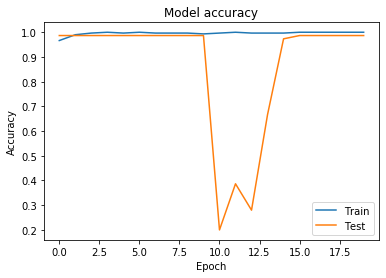

수관-공 모양


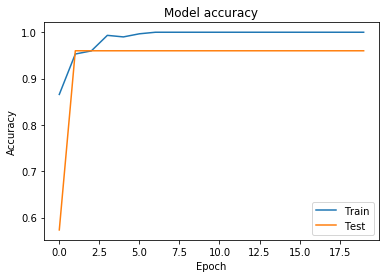

기둥-옹이구멍 안 동물


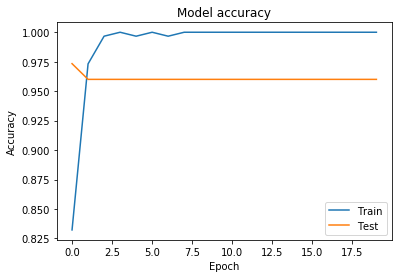

가지-부재


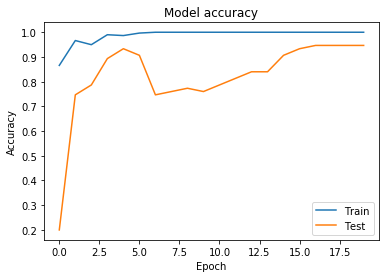

뿌리-부재2


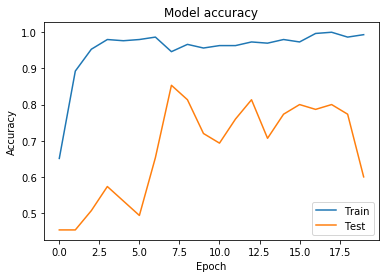

가지-옆으로 벌어짐


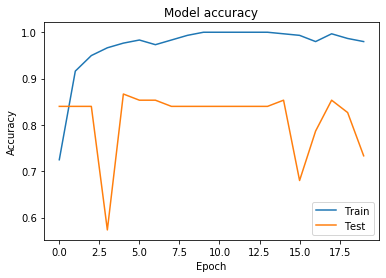

기둥-상처, 옹이구멍


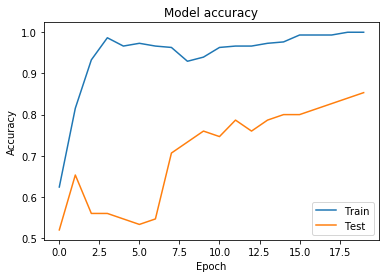

In [16]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['acc'])
        plt.plot(history[i].history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='lower right')
        plt.show()

크기-나무-크다


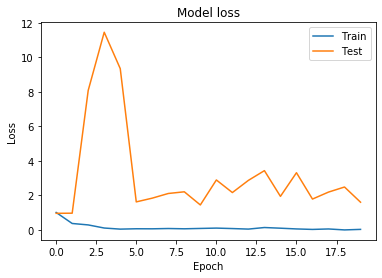

위치-나무-정중앙


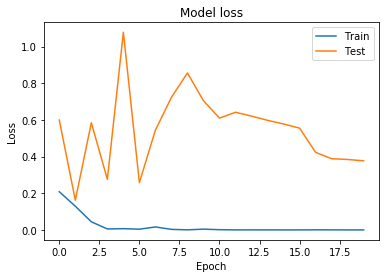

위치-나무-아래


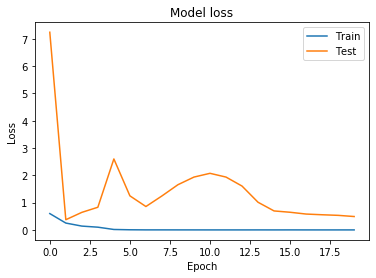

위치-나무-위


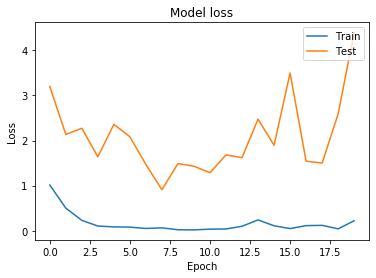

절단-나무-위


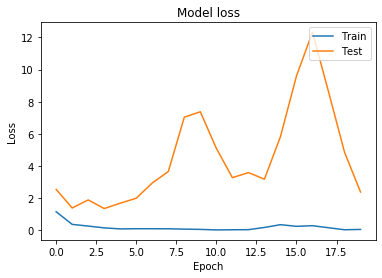

절단-나무-오른쪽


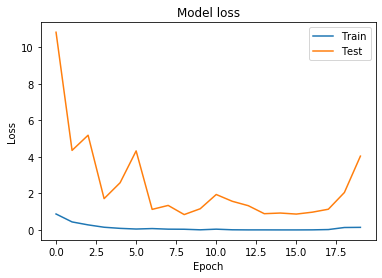

가지-아래로 늘어진 가지


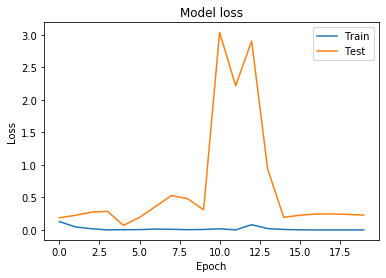

수관-공 모양


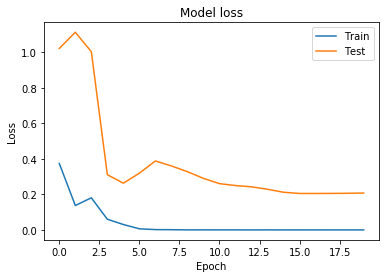

기둥-옹이구멍 안 동물


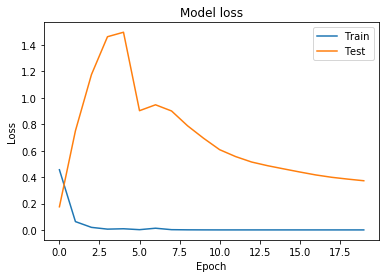

가지-부재


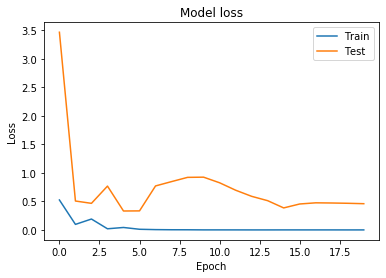

뿌리-부재2


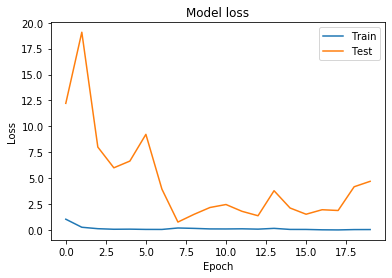

가지-옆으로 벌어짐


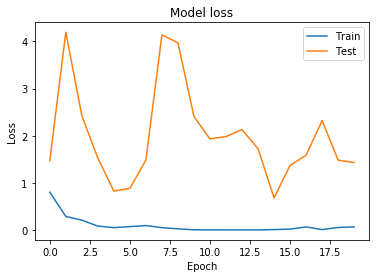

기둥-상처, 옹이구멍


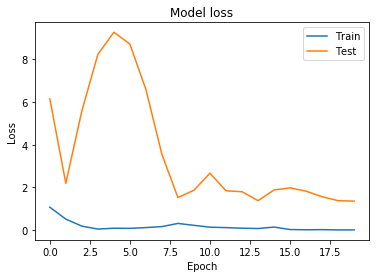

In [17]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['loss'])
        plt.plot(history[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

In [18]:
model_list = []
for num, h in enumerate(tree):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

['크기-나무-크다_mobile_model_0.64_0.9670.h5']
['위치-나무-정중앙_mobile_model_0.96_0.1622.h5', '위치-나무-정중앙_mobile_model_0.97_0.5991.h5']
['위치-나무-아래_mobile_model_0.12_7.2442.h5', '위치-나무-아래_mobile_model_0.87_0.3739.h5']
['위치-나무-위_mobile_model_0.28_3.1981.h5', '위치-나무-위_mobile_model_0.73_1.4670.h5', '위치-나무-위_mobile_model_0.73_1.6392.h5', '위치-나무-위_mobile_model_0.73_2.1351.h5', '위치-나무-위_mobile_model_0.79_0.9103.h5']
['절단-나무-위_mobile_model_0.55_2.5380.h5', '절단-나무-위_mobile_model_0.69_1.3786.h5', '절단-나무-위_mobile_model_0.71_1.3436.h5']
['절단-나무-오른쪽_mobile_model_0.45_4.3516.h5', '절단-나무-오른쪽_mobile_model_0.59_1.7120.h5', '절단-나무-오른쪽_mobile_model_0.69_10.8136.h5', '절단-나무-오른쪽_mobile_model_0.75_1.1247.h5', '절단-나무-오른쪽_mobile_model_0.85_0.8403.h5']
['가지-아래로 늘어진 가지_mobile_model_0.99_0.0690.h5', '가지-아래로 늘어진 가지_mobile_model_0.99_0.1868.h5']
['수관-공 모양_mobile_model_0.57_1.0209.h5', '수관-공 모양_mobile_model_0.96_0.2050.h5', '수관-공 모양_mobile_model_0.96_0.2051.h5', '수관-공 모양_mobile_model_0.96_0.2119.h5', '수관-공 모양_mobile_model_0.96

In [19]:
prediction = []
for i, h in enumerate(tree):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose = 1
        ))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



3/3 [==============================] - 7s 2s/step

3/3 [==============================] - 7s 2s/step

3/3 [==============================] - 8s 3s/step

3/3 [==============================] - 8s 3s/step

3/3 [==============================] - 8s 3s/step

3/3 [==============================] - 8s 3s/step

3/3 [==============================] - 8s 3s/step

3/3 [==============================] - 9s 3s/step

3/3 [==============================] - 9s 3s/step

3/3 [==============================] - 10s 3s/step

3/3 [==============================] - 10s 3s/step

3/3 [==============================] - 10s 3s/step

3/3 [==============================] - 10s 3s/step


In [20]:
for i, h in enumerate(tree):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    # print(submission)
    # print(len(predictions))
    submission[h + '_class'] = predictions
    print(submission.head(10))
    submission.to_excel('h_' + h + '_submission.xlsx', index=False)
    print('='*20)

94
df_test (94, 1)
prediction (94, 2)
   Unnamed: 0        data  크기-나무-크다 크기-나무-크다_class
0         433  0502_T.jpg         1              0
1          71  0072_T.jpg         0              0
2           7  0008_T.jpg         1              1
3         352  0421_T.jpg         1              0
4         444  0513_T.jpg         1              1
5         112  0114_T.jpg         1              1
6         117  0119_T.jpg         0              1
7         333  0402_T.jpg         1              1
8         357  0426_T.jpg         1              0
9         432  0501_T.jpg         1              1
94
df_test (94, 1)
prediction (94, 2)
   Unnamed: 0        data  위치-나무-정중앙 위치-나무-정중앙_class
0         442  0511_T.jpg          0               0
1         324  0393_T.jpg          0               0
2         159  0182_T.jpg          0               0
3         269  0312_T.jpg          0               0
4         101  0102_T.jpg          0               0
5         355  0424_T.jpg          0         

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [0]:
def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [0]:
def recall(y_true, y_pred):
    return recall_score(y_true, y_pred)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
    return ax

크기-나무-크다 : 0.574468085106383
Confusion matrix, without normalization
[[20  9]
 [31 34]]


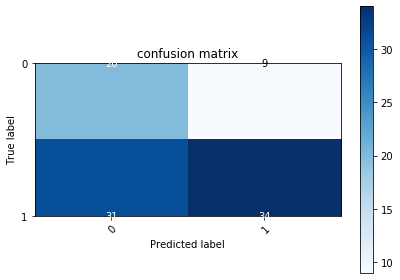

위치-나무-정중앙 : 0.9787234042553191
Confusion matrix, without normalization
[[92  0]
 [ 2  0]]


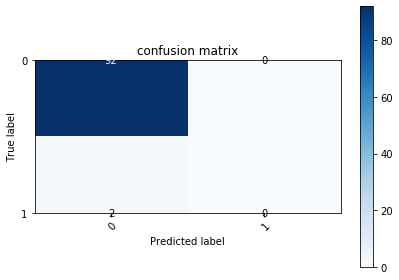

위치-나무-아래 : 0.8404255319148938
Confusion matrix, without normalization
[[69 14]
 [ 1 10]]


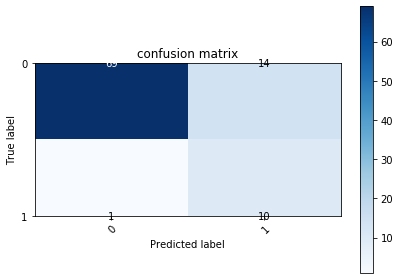

위치-나무-위 : 0.7021276595744681
Confusion matrix, without normalization
[[ 5 19]
 [ 9 61]]


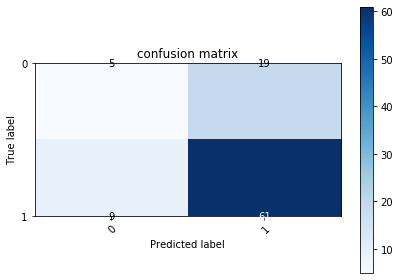

절단-나무-위 : 0.7553191489361702
Confusion matrix, without normalization
[[28 16]
 [ 7 43]]


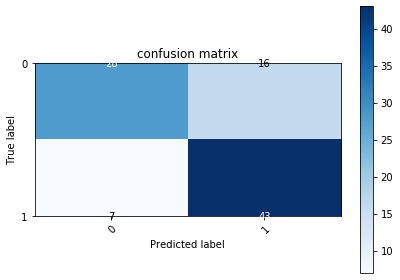

절단-나무-오른쪽 : 0.7872340425531915
Confusion matrix, without normalization
[[63  3]
 [17 11]]


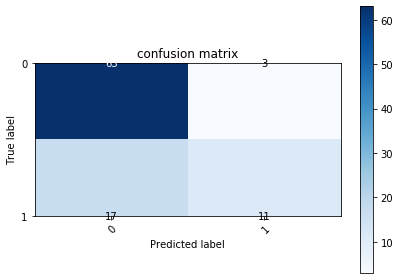

가지-아래로 늘어진 가지 : 0.9893617021276596
Confusion matrix, without normalization
[[93  0]
 [ 1  0]]


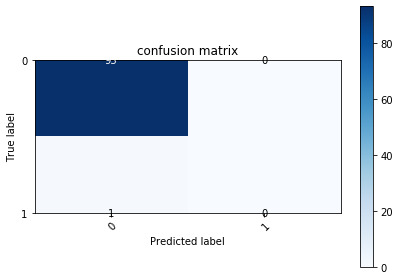

수관-공 모양 : 0.9574468085106385
Confusion matrix, without normalization
[[90  0]
 [ 4  0]]


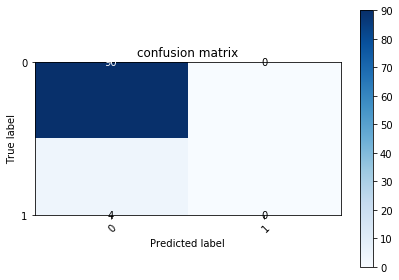

기둥-옹이구멍 안 동물 : 0.925531914893617
Confusion matrix, without normalization
[[87  4]
 [ 3  0]]


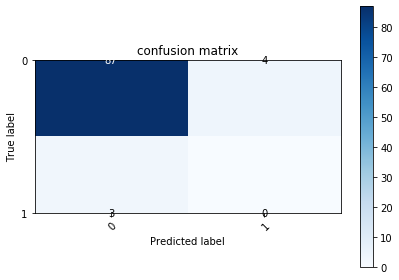

가지-부재 : 0.9468085106382979
Confusion matrix, without normalization
[[84  1]
 [ 4  5]]


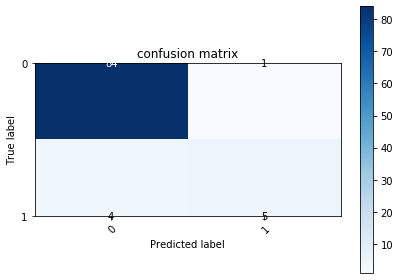

뿌리-부재2 : 0.8404255319148938
Confusion matrix, without normalization
[[38 13]
 [ 2 41]]


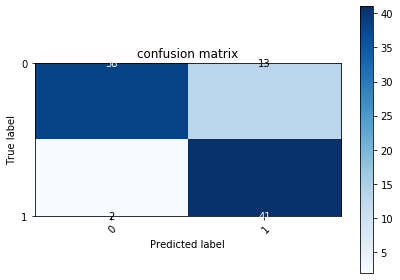

가지-옆으로 벌어짐 : 0.8404255319148938
Confusion matrix, without normalization
[[78  1]
 [14  1]]


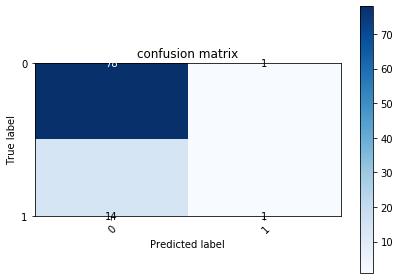

기둥-상처, 옹이구멍 : 0.8404255319148938
Confusion matrix, without normalization
[[40  8]
 [ 7 39]]


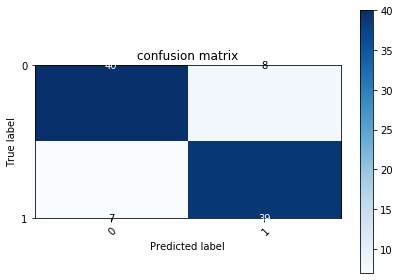

In [44]:
for h in tree:
    try:
        submission = pd.read_excel('h_'+h+'_submission.xlsx')
        print(h, ':', micro_f1(submission[h], submission[h + '_class']))
        plot_confusion_matrix(submission[h],submission[h+'_class'], classes=[0,1],
                              title='confusion matrix')
    except Exception:
        print(e)

In [0]:
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']

    for i in range(len(excel)):
        if(actual[i] == predicted[i]):
            if actual[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if actual[i] == 1:
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP

    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)

    return TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu

In [0]:
bestfeatures = ['가지-부재',
                '위치-나무-아래',
                '가지-옆으로 벌어짐'
                ]

In [47]:
for h in bestfeatures:
    excel = pd.read_excel('./h_'+h+'_submission.xlsx')
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('Flase Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('recall : ', recall(excel[h], excel[h+ '_class']))
    print('negative_predictive_values : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print('f1 score : ', micro_f1(excel[h], excel[h+ '_class']))
    print('='*40)

가지-부재 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  5
False Positive(FP) :  1
Flase Negative(FN) :  89
True Negative(TN) :  93
precision :  0.8333333333333334
recall :  0.5555555555555556
negative_predictive_values :  0.510989010989011
sensitivity :  0.05319148936170213
specificity :  0.9893617021276596
Accuracy :  0.5212765957446809
f1 score :  0.9468085106382979
위치-나무-아래 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  10
False Positive(FP) :  14
Flase Negative(FN) :  84
True Negative(TN) :  80
precision :  0.4166666666666667
recall :  0.9090909090909091
negative_predictive_values :  0.4878048780487805
sensitivity :  0.10638297872340426
specificity :  0.851063829787234
Accuracy :  0.4787234042553192
f1 score :  0.8404255319148938
가지-옆으로 벌어짐 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  1
False Positive(FP) :  1
Flase Negative(FN) :  93
True Negative(TN) :  93
precision :  0.5
recall :  0.06666666666666667
negative_p